# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional

null performances after coercion: 295
after saturation filter 2343
after filter num benchmarks 1515
after merge with model versions 1511
after date filter (>= 2022-11-01) 1334
after merge with benchmark dates 1334
Original number of rows: 1334
Number of rows after aggregation: 995


# Optimized

In [16]:
anchor_mode = "model" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441	

opt_df = scores_df[scores_df['optimized']]

df_opt, df_cm_opt, df_bd_opt = fit_statistical_model(
    # scores_df,
    opt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm_opt['date_obj'] = pd.to_datetime(df_cm_opt['date'])

`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 3.2209e+01, final cost 2.1159e+00, first-order optimality 6.05e-04.


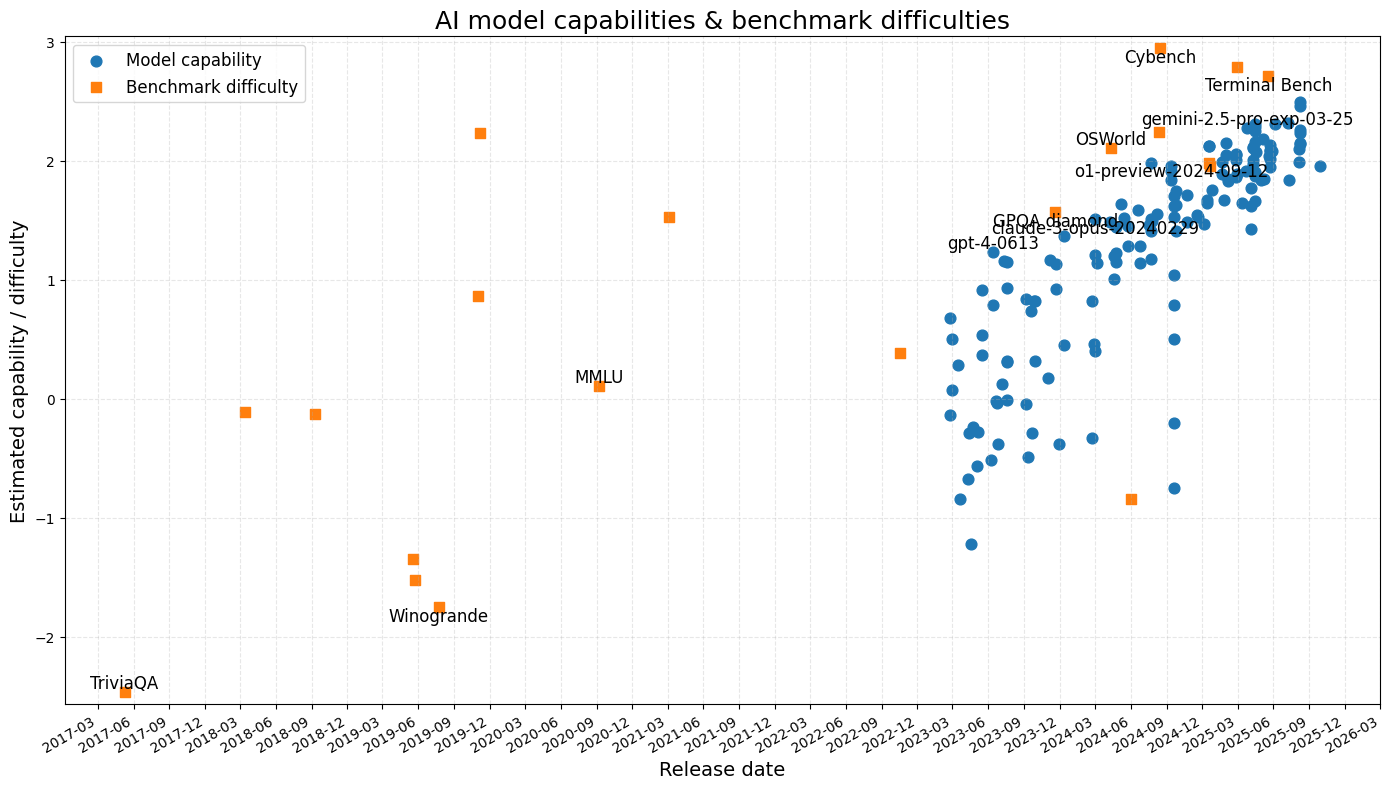

In [17]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_opt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_opt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


[OPTIMIZED - Frontier] Annual growth rate: 0.6754
[OPTIMIZED - Frontier] 95% CI for slope: [0.6094, 0.7413]
[OPTIMIZED - Frontier] R^2: 0.9710
[OPTIMIZED - Frontier] Number of frontier models: 14


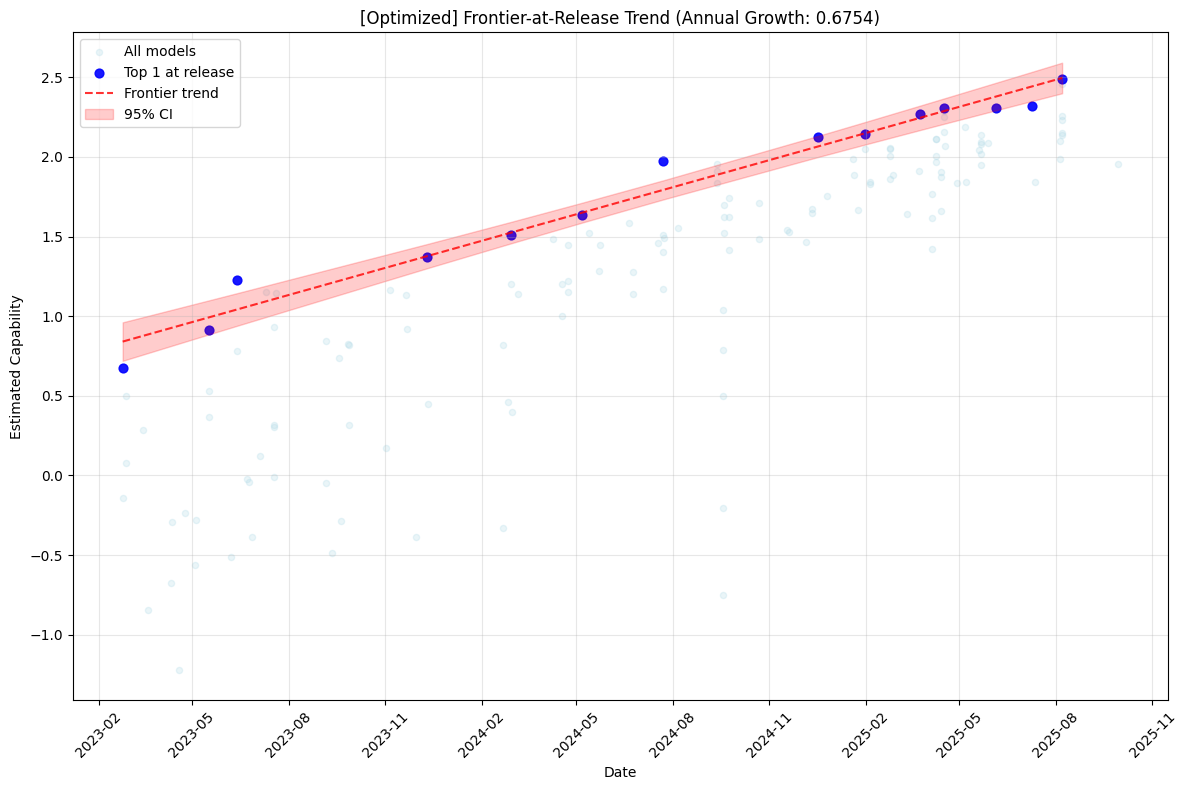

In [18]:
# ── 6) Frontier analysis for optimized benchmarks ─────────────────────────
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

TOP_N_AT_RELEASE = 1  # top-N frontier models (1 = strict SOTA)

# Prepare data for frontier analysis
df_all_opt = df_cm_opt.copy()
df_all_opt['date_obj'] = pd.to_datetime(df_all_opt['date_obj'])
df_all_opt = df_all_opt.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows_opt = []
for _, row in df_all_opt.iterrows():
    release_date = row['date_obj']
    available = df_all_opt[df_all_opt['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows_opt.append(row)

df_frontier_opt = pd.DataFrame(frontier_rows_opt).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier_opt) >= 2:
    X = (df_frontier_opt['date_obj'] - df_frontier_opt['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier_opt['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]
    
    # Print with CI
    print(f"[OPTIMIZED - Frontier] Annual growth rate: {slope_per_year:.4f}")
    print(f"[OPTIMIZED - Frontier] 95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
          f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]")
    print(f"[OPTIMIZED - Frontier] R^2: {r2:.4f}")
    print(f"[OPTIMIZED - Frontier] Number of frontier models: {len(df_frontier_opt)}")
    
    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(df_all_opt['date_obj'], df_all_opt['estimated_capability'], 
               alpha=0.25, s=20, label='All models', color='lightblue')
    ax.scatter(df_frontier_opt['date_obj'], df_frontier_opt['estimated_capability'], 
               alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')
    ax.plot(df_frontier_opt['date_obj'], lr.predict(X), 'r--', alpha=0.8, label='Frontier trend')
    
    # Add confidence band
    ax.fill_between(df_frontier_opt['date_obj'], ci_lower, ci_upper, 
                     alpha=0.2, color='red', label='95% CI')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'[Optimized] Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("[OPTIMIZED - Frontier] Not enough frontier models for analysis")



Bootstrapped mean rate: 0.9605 capability units/year
95% confidence interval: [0.8622, 1.0629]


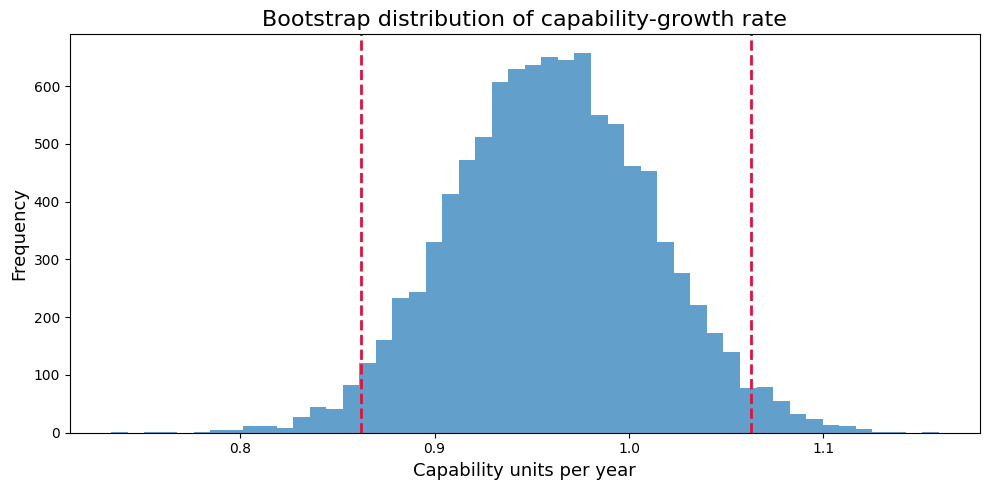

In [19]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
import numpy as np

n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]                       # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()               # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

# Unoptimized

In [20]:

anchor_mode = "model" # "model", "benchmark"
anchor_benchmark = "Balrog"
anchor_difficulty = 2.628412
anchor_slope = 1.233816
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441	

unopt_df = scores_df[~scores_df['optimized']]

df_unopt, df_cm_unopt, df_bd_unopt = fit_statistical_model(
    unopt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm_unopt['date_obj'] = pd.to_datetime(df_cm_unopt['date'])

`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 5.9340e+00, final cost 5.2450e-01, first-order optimality 6.54e-05.


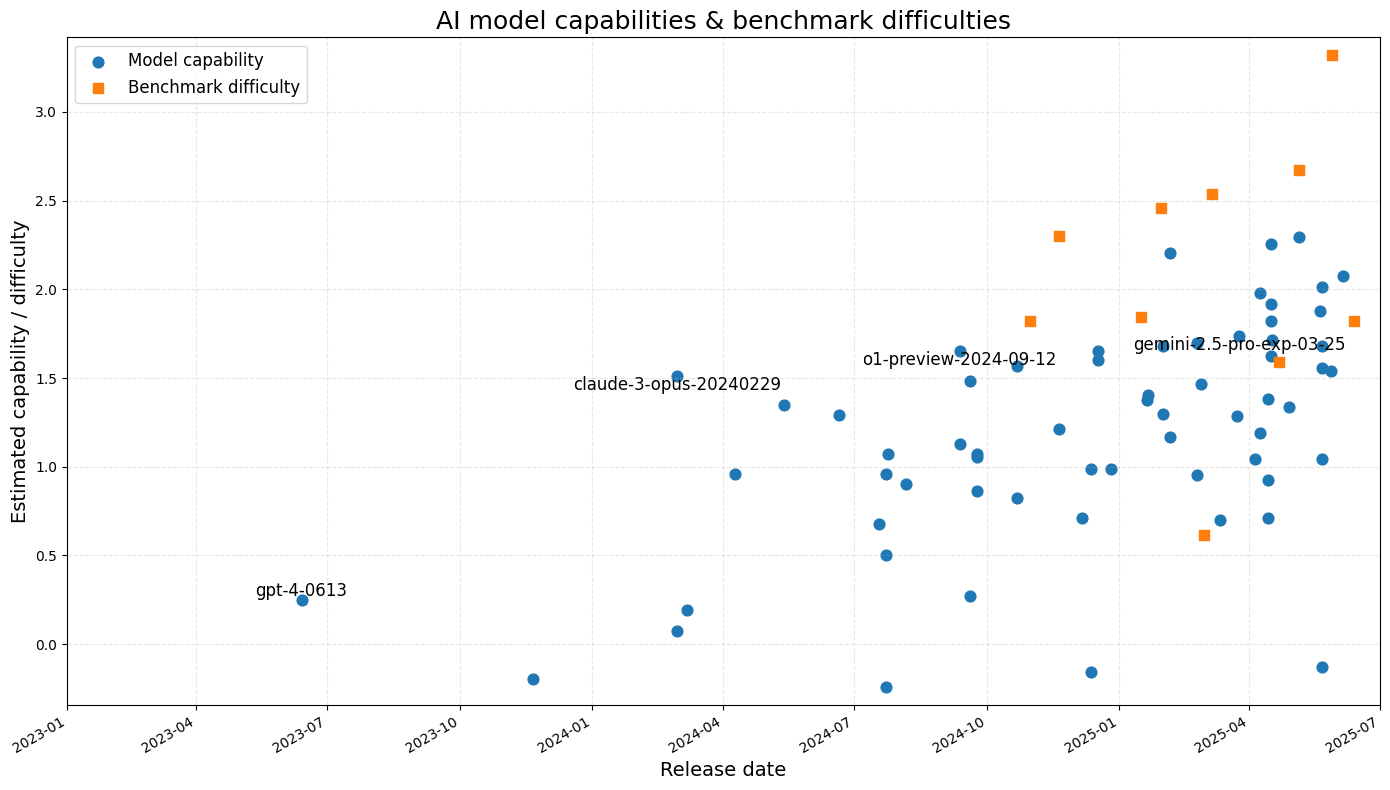

In [21]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_unopt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_unopt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.8045 capability units/year
95% confidence interval: [0.5430, 1.0676]


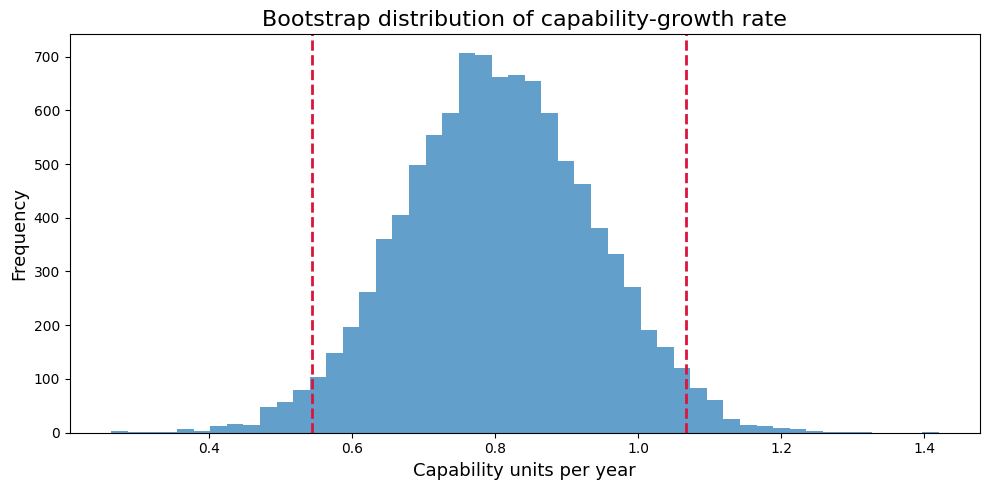

In [22]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask  = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]                       # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()               # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

[UNOPTIMIZED - Frontier] Annual growth rate: 1.0509
[UNOPTIMIZED - Frontier] 95% CI for slope: [0.7713, 1.3304]
[UNOPTIMIZED - Frontier] R^2: 0.9005
[UNOPTIMIZED - Frontier] Number of frontier models: 8


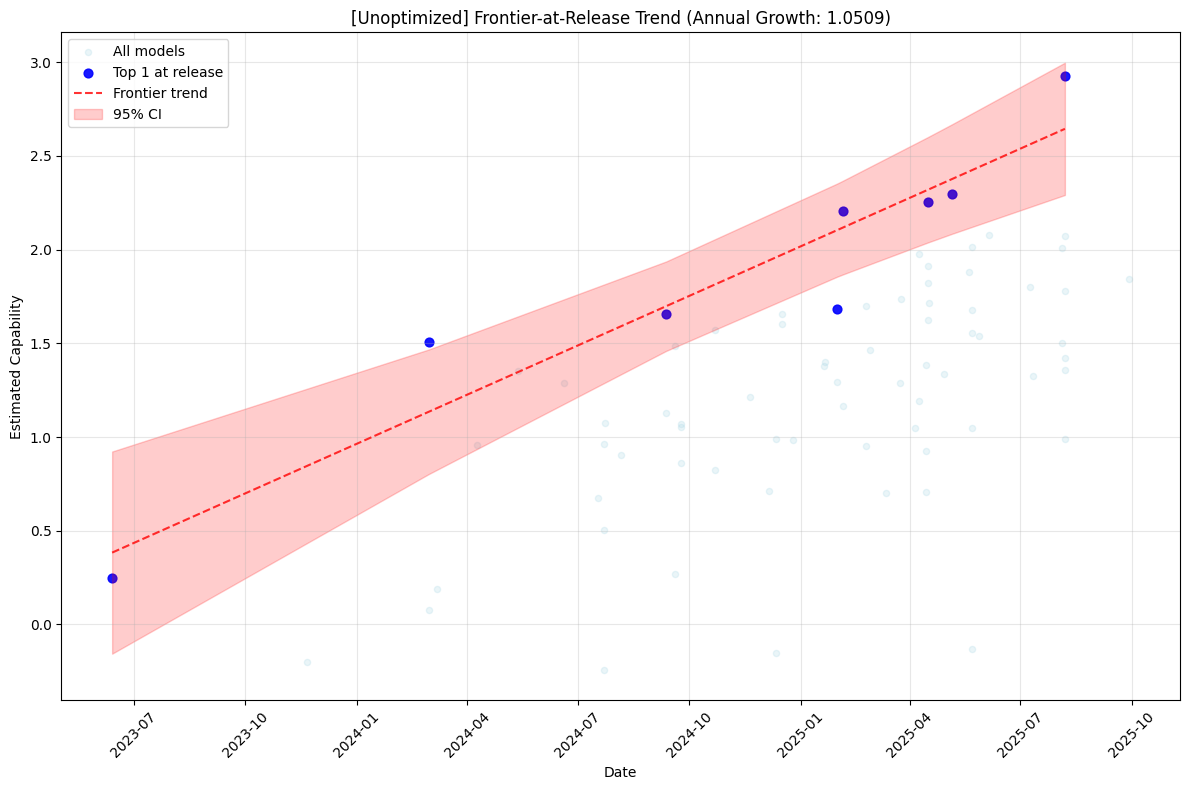

In [23]:
# ── 11) Frontier analysis for unoptimized benchmarks ──────────────────────
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

TOP_N_AT_RELEASE = 1  # top-N frontier models (1 = strict SOTA)

# Prepare data for frontier analysis
df_all_unopt = df_cm_unopt.copy()
df_all_unopt['date_obj'] = pd.to_datetime(df_all_unopt['date_obj'])
df_all_unopt = df_all_unopt.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows_unopt = []
for _, row in df_all_unopt.iterrows():
    release_date = row['date_obj']
    available = df_all_unopt[df_all_unopt['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows_unopt.append(row)

df_frontier_unopt = pd.DataFrame(frontier_rows_unopt).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier_unopt) >= 2:
    X = (df_frontier_unopt['date_obj'] - df_frontier_unopt['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier_unopt['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]
    
    # Print with CI
    print(f"[UNOPTIMIZED - Frontier] Annual growth rate: {slope_per_year:.4f}")
    print(f"[UNOPTIMIZED - Frontier] 95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
          f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]")
    print(f"[UNOPTIMIZED - Frontier] R^2: {r2:.4f}")
    print(f"[UNOPTIMIZED - Frontier] Number of frontier models: {len(df_frontier_unopt)}")
    
    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(df_all_unopt['date_obj'], df_all_unopt['estimated_capability'], 
               alpha=0.25, s=20, label='All models', color='lightblue')
    ax.scatter(df_frontier_unopt['date_obj'], df_frontier_unopt['estimated_capability'], 
               alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')
    ax.plot(df_frontier_unopt['date_obj'], lr.predict(X), 'r--', alpha=0.8, label='Frontier trend')
    
    # Add confidence band
    ax.fill_between(df_frontier_unopt['date_obj'], ci_lower, ci_upper, 
                     alpha=0.2, color='red', label='95% CI')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'[Unoptimized] Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("[UNOPTIMIZED - Frontier] Not enough frontier models for analysis")



In [26]:
df_frontier_opt

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj
0,m125,0.677298,LLaMA-65B,False,LLaMA-65B,2023-02-24,2023-02-24
1,m108,0.914329,PaLM 2-L,False,NaN,2023-05-17,2023-05-17
2,m16,1.230356,gpt-4-0613,False,GPT-4,2023-06-13,2023-06-13
3,m100,1.369145,Mixtral-8x7B-v0.1,False,Mixtral 8x7B,2023-12-11,2023-12-11
4,m4,1.510032,claude-3-opus-20240229,True,Claude 3 Opus,2024-02-29,2024-02-29
5,m133,1.634851,DeepSeek-V2,False,DeepSeek-V2 (MoE-236B),2024-05-07,2024-05-07
6,m135,1.976465,Llama-3.1-405B,False,Llama 3.1-405B,2024-07-23,2024-07-23
7,m34,2.126891,o1-2024-12-17_medium,False,o1,2024-12-17,2024-12-17
8,m43,2.146773,o3-mini-2025-01-31_high,False,o3-mini,2025-01-31,2025-01-31
9,m54,2.270680,gemini-2.5-pro-exp-03-25,False,Gemini 2.5 Pro,2025-03-25,2025-03-25


In [25]:
df_frontier_unopt

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj
0,m16,0.250538,gpt-4-0613,False,GPT-4,2023-06-13,2023-06-13
1,m4,1.510032,claude-3-opus-20240229,True,Claude 3 Opus,2024-02-29,2024-02-29
2,m7,1.654966,o1-preview-2024-09-12,False,o1-preview,2024-09-12,2024-09-12
3,m36,1.681850,o3-mini-2025-01-31_medium,False,o3-mini,2025-01-31,2025-01-31
4,m42,2.204818,gemini-2.0-pro-exp-02-05,False,Gemini 2.0 Pro,2025-02-05,2025-02-05
5,m89,2.254632,o3-2025-04-16_medium,False,o3,2025-04-16,2025-04-16
6,m76,2.296430,gemini-2.5-pro-preview-05-06,False,Gemini 2.5 Pro,2025-05-06,2025-05-06
7,m85,2.927396,gpt-5-2025-08-07_medium,False,GPT-5,2025-08-07,2025-08-07


# Comparison: Optimized vs Unoptimized Capability Estimates


In [28]:
# ── Compare model capabilities: Optimized vs Unoptimized datasets ──────────

# Merge the two capability datasets
comparison_df = df_cm_opt[['model', 'estimated_capability', 'date']].merge(
    df_cm_unopt[['model', 'estimated_capability']],
    on='model',
    suffixes=('_opt', '_unopt'),
    how='inner'  # Only keep models that appear in both datasets
)

# Calculate the difference
comparison_df['capability_diff'] = comparison_df['estimated_capability_opt'] - comparison_df['estimated_capability_unopt']
comparison_df['capability_ratio'] = comparison_df['estimated_capability_opt'] / comparison_df['estimated_capability_unopt']

# Sort by absolute difference
comparison_df_sorted = comparison_df.sort_values('capability_diff', ascending=False).reset_index(drop=True)

print("="*80)
print("MODELS IN BOTH OPTIMIZED AND UNOPTIMIZED DATASETS")
print("="*80)
print(f"\nTotal models in optimized dataset: {len(df_cm_opt)}")
print(f"Total models in unoptimized dataset: {len(df_cm_unopt)}")
print(f"Models appearing in BOTH datasets: {len(comparison_df)}")

print(f"\n\nDIFFERENCE STATISTICS:")
print("-"*80)
print(f"Mean difference (opt - unopt): {comparison_df['capability_diff'].mean():.4f}")
print(f"Median difference: {comparison_df['capability_diff'].median():.4f}")
print(f"Std dev of difference: {comparison_df['capability_diff'].std():.4f}")
print(f"Max positive difference: {comparison_df['capability_diff'].max():.4f}")
print(f"Max negative difference: {comparison_df['capability_diff'].min():.4f}")

print(f"\n\nRATIO STATISTICS:")
print("-"*80)
print(f"Mean ratio (opt / unopt): {comparison_df['capability_ratio'].mean():.4f}")
print(f"Median ratio: {comparison_df['capability_ratio'].median():.4f}")

# Perform paired t-test
from scipy.stats import ttest_rel, wilcoxon
t_stat, t_pvalue = ttest_rel(comparison_df['estimated_capability_opt'], 
                               comparison_df['estimated_capability_unopt'])
w_stat, w_pvalue = wilcoxon(comparison_df['estimated_capability_opt'], 
                              comparison_df['estimated_capability_unopt'])

print(f"\n\nSTATISTICAL TESTS:")
print("-"*80)
print(f"Paired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_pvalue:.6f}")
print(f"  Interpretation: Capabilities are {'SIGNIFICANTLY DIFFERENT' if t_pvalue < 0.05 else 'NOT significantly different'} (α=0.05)")

print(f"\nWilcoxon signed-rank test (non-parametric):")
print(f"  statistic: {w_stat:.4f}")
print(f"  p-value: {w_pvalue:.6f}")
print(f"  Interpretation: Capabilities are {'SIGNIFICANTLY DIFFERENT' if w_pvalue < 0.05 else 'NOT significantly different'} (α=0.05)")

print(f"\n\nTOP 10 MODELS WITH LARGEST POSITIVE DIFFERENCE (higher on optimized):")
print("-"*80)
for i, row in comparison_df_sorted.head(10).iterrows():
    print(f"{row['model']:45s} | Opt: {row['estimated_capability_opt']:.4f} | Unopt: {row['estimated_capability_unopt']:.4f} | Diff: +{row['capability_diff']:.4f}")

print(f"\n\nTOP 10 MODELS WITH LARGEST NEGATIVE DIFFERENCE (higher on unoptimized):")
print("-"*80)
for i, row in comparison_df_sorted.tail(10).iterrows():
    print(f"{row['model']:45s} | Opt: {row['estimated_capability_opt']:.4f} | Unopt: {row['estimated_capability_unopt']:.4f} | Diff: {row['capability_diff']:.4f}")

print("="*80)



MODELS IN BOTH OPTIMIZED AND UNOPTIMIZED DATASETS

Total models in optimized dataset: 146
Total models in unoptimized dataset: 74
Models appearing in BOTH datasets: 74


DIFFERENCE STATISTICS:
--------------------------------------------------------------------------------
Mean difference (opt - unopt): 0.5753
Median difference: 0.5353
Std dev of difference: 0.4468
Max positive difference: 2.2629
Max negative difference: -0.4356


RATIO STATISTICS:
--------------------------------------------------------------------------------
Mean ratio (opt / unopt): 1.2141
Median ratio: 1.3567


STATISTICAL TESTS:
--------------------------------------------------------------------------------
Paired t-test:
  t-statistic: 11.0763
  p-value: 0.000000
  Interpretation: Capabilities are SIGNIFICANTLY DIFFERENT (α=0.05)

Wilcoxon signed-rank test (non-parametric):
  statistic: 48.0000
  p-value: 0.000000
  Interpretation: Capabilities are SIGNIFICANTLY DIFFERENT (α=0.05)


TOP 10 MODELS WITH LARGEST P

/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_28183/3288099487.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=['Optimized', 'Unoptimized'],


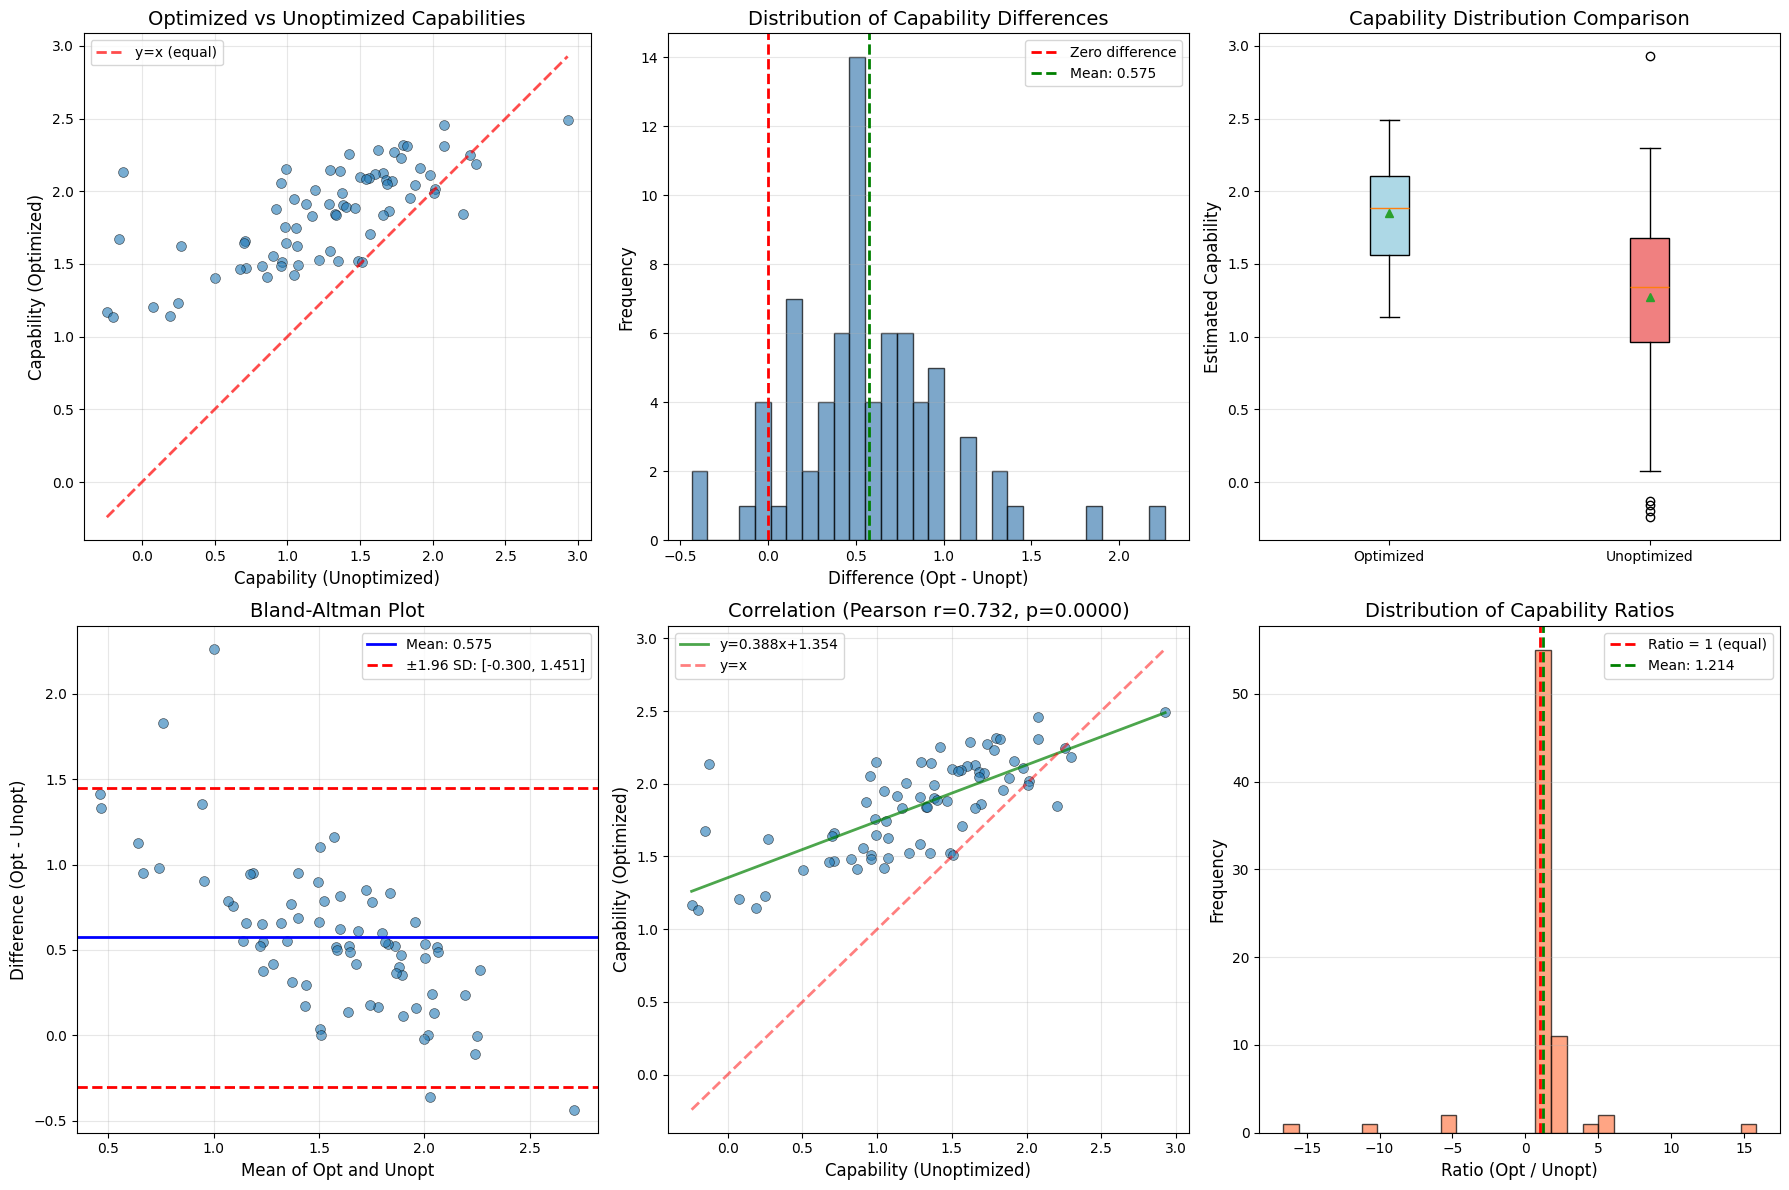


Correlation Statistics:
  Pearson correlation: r=0.7322, p=0.000000
  Spearman correlation: ρ=0.7236, p=0.000000


In [29]:
# ── Visualizations: Optimized vs Unoptimized Comparison ────────────────────

# Create a comprehensive comparison plot
fig = plt.figure(figsize=(18, 12))

# 1. Scatter plot: Optimized vs Unoptimized capabilities
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(comparison_df['estimated_capability_unopt'], 
            comparison_df['estimated_capability_opt'],
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Add diagonal line (y=x)
min_val = min(comparison_df['estimated_capability_opt'].min(), 
              comparison_df['estimated_capability_unopt'].min())
max_val = max(comparison_df['estimated_capability_opt'].max(), 
              comparison_df['estimated_capability_unopt'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7, label='y=x (equal)')
ax1.set_xlabel('Capability (Unoptimized)', fontsize=12)
ax1.set_ylabel('Capability (Optimized)', fontsize=12)
ax1.set_title('Optimized vs Unoptimized Capabilities', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal', adjustable='box')

# 2. Histogram of differences
ax2 = plt.subplot(2, 3, 2)
ax2.hist(comparison_df['capability_diff'], bins=30, alpha=0.7, edgecolor='black', color='steelblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero difference')
ax2.axvline(comparison_df['capability_diff'].mean(), color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {comparison_df["capability_diff"].mean():.3f}')
ax2.set_xlabel('Difference (Opt - Unopt)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Capability Differences', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

# 3. Box plot comparison
ax3 = plt.subplot(2, 3, 3)
data_to_plot = [comparison_df['estimated_capability_opt'], 
                comparison_df['estimated_capability_unopt']]
bp = ax3.boxplot(data_to_plot, labels=['Optimized', 'Unoptimized'], 
                  patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax3.set_ylabel('Estimated Capability', fontsize=12)
ax3.set_title('Capability Distribution Comparison', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Bland-Altman plot (difference vs average)
ax4 = plt.subplot(2, 3, 4)
mean_capabilities = (comparison_df['estimated_capability_opt'] + 
                     comparison_df['estimated_capability_unopt']) / 2
differences = comparison_df['capability_diff']
mean_diff = differences.mean()
std_diff = differences.std()

ax4.scatter(mean_capabilities, differences, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax4.axhline(mean_diff, color='blue', linestyle='-', linewidth=2, label=f'Mean: {mean_diff:.3f}')
ax4.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', linewidth=2, 
            label=f'±1.96 SD: [{mean_diff-1.96*std_diff:.3f}, {mean_diff+1.96*std_diff:.3f}]')
ax4.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Mean of Opt and Unopt', fontsize=12)
ax4.set_ylabel('Difference (Opt - Unopt)', fontsize=12)
ax4.set_title('Bland-Altman Plot', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5. Correlation scatter with regression line
ax5 = plt.subplot(2, 3, 5)
from scipy.stats import pearsonr, spearmanr
r_pearson, p_pearson = pearsonr(comparison_df['estimated_capability_opt'], 
                                 comparison_df['estimated_capability_unopt'])
r_spearman, p_spearman = spearmanr(comparison_df['estimated_capability_opt'], 
                                    comparison_df['estimated_capability_unopt'])

ax5.scatter(comparison_df['estimated_capability_unopt'], 
            comparison_df['estimated_capability_opt'],
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Add regression line
z = np.polyfit(comparison_df['estimated_capability_unopt'], 
               comparison_df['estimated_capability_opt'], 1)
p = np.poly1d(z)
x_line = np.linspace(comparison_df['estimated_capability_unopt'].min(), 
                     comparison_df['estimated_capability_unopt'].max(), 100)
ax5.plot(x_line, p(x_line), "g-", linewidth=2, alpha=0.7, 
         label=f'y={z[0]:.3f}x+{z[1]:.3f}')
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')

ax5.set_xlabel('Capability (Unoptimized)', fontsize=12)
ax5.set_ylabel('Capability (Optimized)', fontsize=12)
ax5.set_title(f'Correlation (Pearson r={r_pearson:.3f}, p={p_pearson:.4f})', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. Histogram of ratios
ax6 = plt.subplot(2, 3, 6)
ax6.hist(comparison_df['capability_ratio'], bins=30, alpha=0.7, edgecolor='black', color='coral')
ax6.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1 (equal)')
ax6.axvline(comparison_df['capability_ratio'].mean(), color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {comparison_df["capability_ratio"].mean():.3f}')
ax6.set_xlabel('Ratio (Opt / Unopt)', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('Distribution of Capability Ratios', fontsize=14)
ax6.grid(True, alpha=0.3, axis='y')
ax6.legend()

plt.tight_layout()
plt.savefig("optimized_vs_unoptimized_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCorrelation Statistics:")
print(f"  Pearson correlation: r={r_pearson:.4f}, p={p_pearson:.6f}")
print(f"  Spearman correlation: ρ={r_spearman:.4f}, p={p_spearman:.6f}")



In [42]:
scores_df

,model_id,benchmark_id,performance,benchmark,benchmark_release_date,optimized,is_math,is_coding,model,date,source
0,m1,b1,0.870,GPQA diamond,2023-11-20,True,False,False,grok-4-0709,2025-07-09,Epoch evaluations
1,m1,b10,0.436,Balrog,2024-11-20,False,False,False,grok-4-0709,2025-07-09,None
2,m1,b16,0.548,DeepResearch Bench,2025-06-13,False,False,False,grok-4-0709,2025-07-09,DeepResearchBench Leaderboard
3,m1,b18,0.450,GeoBench,2025-03-01,False,False,False,grok-4-0709,2025-07-09,GeoBench leaderboard
4,m1,b2,0.121,FrontierMath-2025-02-28-Private,2025-02-28,True,True,False,grok-4-0709,2025-07-09,Epoch evaluations
...,...,...,...,...,...,...,...,...,...,...,...
990,m99,b22,0.786,OpenBookQA,2018-09-08,True,False,False,gemma-7b,2024-02-21,Phi-3 Technical Report: A Highly Capable Langu...
991,m99,b27,0.723,TriviaQA,2017-05-09,True,False,False,gemma-7b,2024-02-21,Gemma: Open Models Based on Gemini Research an...
992,m99,b31,0.790,Winogrande,2019-07-24,True,False,False,gemma-7b,2024-02-21,Gemma: Open Models Based on Gemini Research an...
993,m99,b7,0.487,ANLI,2019-10-31,True,False,False,gemma-7b,2024-02-21,Phi-3 Technical Report: A Highly Capable Langu...


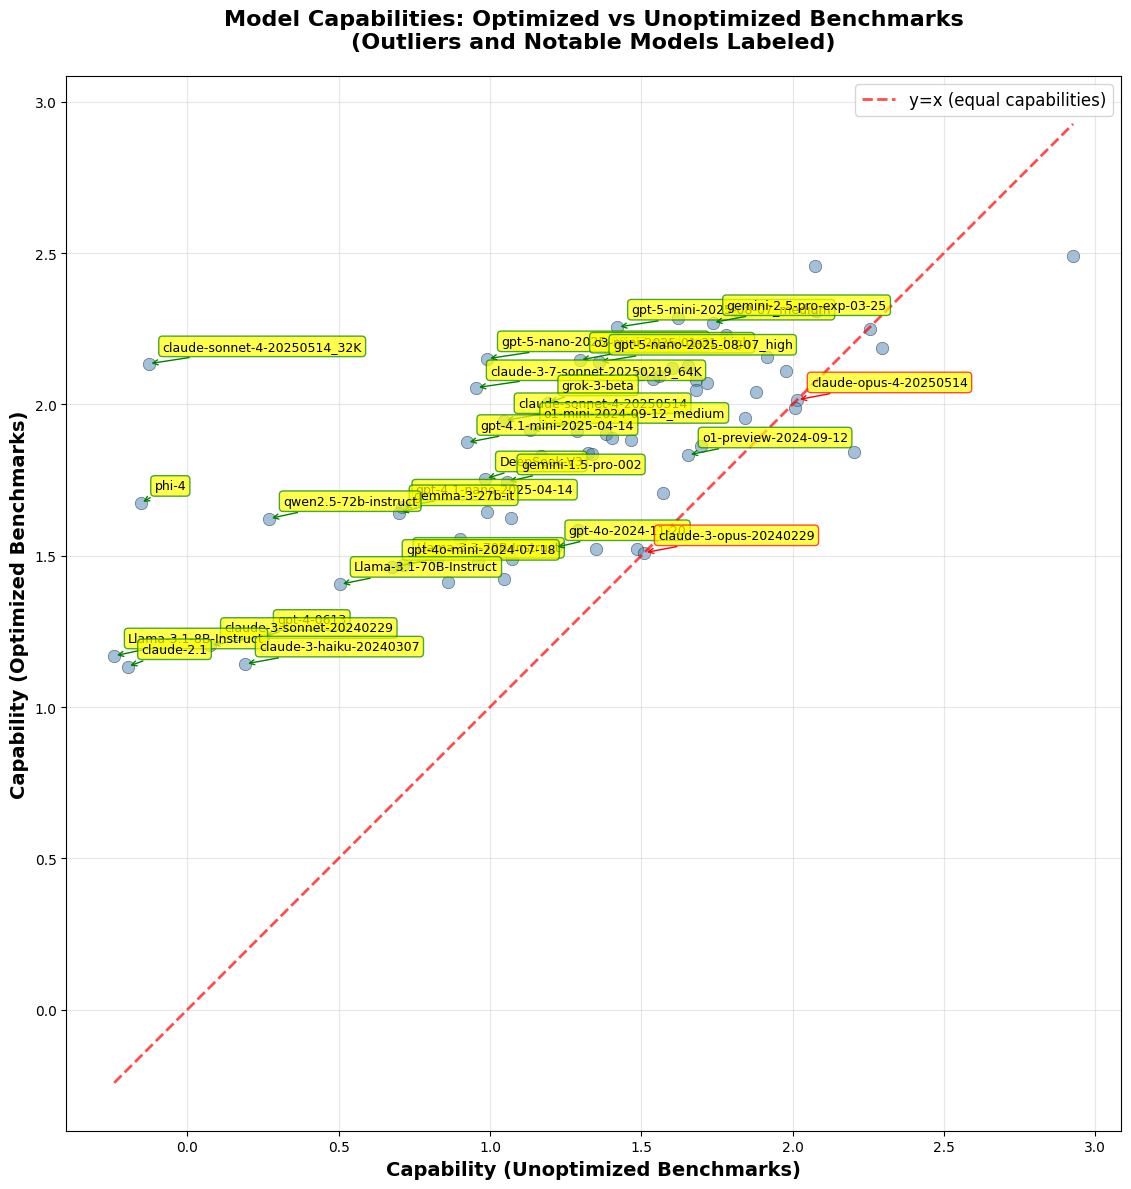


Labeled 29 models on the plot
  - Outliers (|diff| > 0.670): 24
  - Notable models: 5


In [30]:
# ── Detailed scatter plot with model labels ────────────────────────────────

# Create scatter plot with model labels for outliers and notable models
fig, ax = plt.subplots(figsize=(16, 12))

# Scatter all points
ax.scatter(comparison_df['estimated_capability_unopt'], 
           comparison_df['estimated_capability_opt'],
           alpha=0.5, s=80, edgecolors='black', linewidth=0.5, color='steelblue')

# Add diagonal line (y=x)
min_val = min(comparison_df['estimated_capability_opt'].min(), 
              comparison_df['estimated_capability_unopt'].min())
max_val = max(comparison_df['estimated_capability_opt'].max(), 
              comparison_df['estimated_capability_unopt'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7, label='y=x (equal capabilities)')

# Identify outliers (models with large differences)
threshold = comparison_df['capability_diff'].std() * 1.5
outliers = comparison_df[np.abs(comparison_df['capability_diff']) > threshold]

# Also highlight some notable models
notable_models = [
    'gpt-4-0613',
    'claude-3-opus-20240229',
    'gemini-2.5-pro-exp-03-25',
    'o1-preview-2024-09-12',
    'gpt-4o-2024-11-20',
    'claude-opus-4-20250514',
]

# Combine outliers and notable models
models_to_label = pd.concat([
    outliers,
    comparison_df[comparison_df['model'].isin(notable_models)]
]).drop_duplicates(subset='model')

# Label these models
for idx, row in models_to_label.iterrows():
    # Determine color based on difference
    color = 'green' if row['capability_diff'] > 0 else 'red'
    
    # Add arrow and label
    ax.annotate(row['model'], 
                xy=(row['estimated_capability_unopt'], row['estimated_capability_opt']),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=9,
                ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor=color),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1, color=color))

ax.set_xlabel('Capability (Unoptimized Benchmarks)', fontsize=14, fontweight='bold')
ax.set_ylabel('Capability (Optimized Benchmarks)', fontsize=14, fontweight='bold')
ax.set_title('Model Capabilities: Optimized vs Unoptimized Benchmarks\n(Outliers and Notable Models Labeled)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig("optimized_vs_unoptimized_labeled.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLabeled {len(models_to_label)} models on the plot")
print(f"  - Outliers (|diff| > {threshold:.3f}): {len(outliers)}")
print(f"  - Notable models: {len(models_to_label) - len(outliers)}")



In [31]:
# ── Export comparison data and summary insights ────────────────────────────

# Save the comparison DataFrame for further analysis
comparison_export = comparison_df[['model', 'date', 
                                   'estimated_capability_opt', 
                                   'estimated_capability_unopt',
                                   'capability_diff', 
                                   'capability_ratio']].copy()

comparison_export = comparison_export.sort_values('capability_diff', ascending=False)
comparison_export.to_csv('outputs/model_capability_comparison_opt_vs_unopt.csv', index=False)
print("Saved comparison data to: outputs/model_capability_comparison_opt_vs_unopt.csv")

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS FROM COMPARISON")
print("="*80)

# Count models by direction of difference
higher_on_opt = len(comparison_df[comparison_df['capability_diff'] > 0])
higher_on_unopt = len(comparison_df[comparison_df['capability_diff'] < 0])
equal = len(comparison_df[comparison_df['capability_diff'] == 0])

print(f"\nDistribution of differences:")
print(f"  • Models with higher capability on OPTIMIZED benchmarks: {higher_on_opt} ({100*higher_on_opt/len(comparison_df):.1f}%)")
print(f"  • Models with higher capability on UNOPTIMIZED benchmarks: {higher_on_unopt} ({100*higher_on_unopt/len(comparison_df):.1f}%)")
print(f"  • Models with equal capability: {equal}")

# Statistical significance interpretation
print(f"\n\nStatistical interpretation:")
if t_pvalue < 0.001:
    print(f"  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)")
elif t_pvalue < 0.05:
    print(f"  ✓ SIGNIFICANT difference (p < 0.05)")
else:
    print(f"  ✗ NO significant difference (p ≥ 0.05)")

mean_diff = comparison_df['capability_diff'].mean()
if abs(mean_diff) > 0.1:
    direction = "HIGHER on optimized" if mean_diff > 0 else "HIGHER on unoptimized"
    print(f"  • On average, models score {direction} benchmarks by {abs(mean_diff):.4f} capability units")
else:
    print(f"  • On average, the difference is small ({mean_diff:.4f} capability units)")

# Correlation interpretation
if r_pearson > 0.9:
    print(f"\n  ✓ VERY STRONG correlation (r={r_pearson:.3f}) between opt and unopt capabilities")
    print(f"    → Models that perform well on one type generally perform well on the other")
elif r_pearson > 0.7:
    print(f"\n  ✓ STRONG correlation (r={r_pearson:.3f}) between opt and unopt capabilities")
    print(f"    → Models show consistent performance across both benchmark types")
else:
    print(f"\n  ⚠ MODERATE correlation (r={r_pearson:.3f}) between opt and unopt capabilities")
    print(f"    → Performance on one type doesn't strongly predict the other")

# Identify patterns
high_diff_models = comparison_df[comparison_df['capability_diff'] > comparison_df['capability_diff'].quantile(0.9)]
print(f"\n\nModels with unusually high performance on optimized benchmarks:")
print(f"  (Top 10% by difference)")
for idx, row in high_diff_models.head(5).iterrows():
    print(f"  • {row['model']}: Δ = +{row['capability_diff']:.4f}")

low_diff_models = comparison_df[comparison_df['capability_diff'] < comparison_df['capability_diff'].quantile(0.1)]
print(f"\n\nModels with unusually high performance on unoptimized benchmarks:")
print(f"  (Bottom 10% by difference)")
for idx, row in low_diff_models.head(5).iterrows():
    print(f"  • {row['model']}: Δ = {row['capability_diff']:.4f}")

print("\n" + "="*80)



Saved comparison data to: outputs/model_capability_comparison_opt_vs_unopt.csv

KEY INSIGHTS FROM COMPARISON

Distribution of differences:
  • Models with higher capability on OPTIMIZED benchmarks: 67 (90.5%)
  • Models with higher capability on UNOPTIMIZED benchmarks: 5 (6.8%)
  • Models with equal capability: 2


Statistical interpretation:
  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)
  • On average, models score HIGHER on optimized benchmarks by 0.5753 capability units

  ✓ STRONG correlation (r=0.732) between opt and unopt capabilities
    → Models show consistent performance across both benchmark types


Models with unusually high performance on optimized benchmarks:
  (Top 10% by difference)
  • gpt-5-nano-2025-08-07_medium: Δ = +1.1600
  • claude-sonnet-4-20250514_32K: Δ = +2.2629
  • claude-3-7-sonnet-20250219_64K: Δ = +1.1010
  • phi-4: Δ = +1.8281
  • qwen2.5-72b-instruct: Δ = +1.3525


Models with unusually high performance on unoptimized benchmarks:
  (Bottom 10% by differ

# Random Partition Comparison (Robustness Check)


In [34]:
# ── Check if anchor models are in the dataset ──────────────────────────────

anchor_model1 = "claude-3-opus-20240229"
anchor_model2 = "claude-opus-4-20250514"

print("Checking anchor models in dataset:")
print(f"  {anchor_model1} in data: {anchor_model1 in scores_df['model'].values}")
print(f"  {anchor_model2} in data: {anchor_model2 in scores_df['model'].values}")

# Check in optimized and unoptimized subsets
print(f"\nIn optimized subset:")
print(f"  {anchor_model1}: {anchor_model1 in opt_df['model'].values}")
print(f"  {anchor_model2}: {anchor_model2 in opt_df['model'].values}")

print(f"\nIn unoptimized subset:")
print(f"  {anchor_model1}: {anchor_model1 in unopt_df['model'].values}")
print(f"  {anchor_model2}: {anchor_model2 in unopt_df['model'].values}")



Checking anchor models in dataset:
  claude-3-opus-20240229 in data: True
  claude-opus-4-20250514 in data: True

In optimized subset:
  claude-3-opus-20240229: True
  claude-opus-4-20250514: True

In unoptimized subset:
  claude-3-opus-20240229: True
  claude-opus-4-20250514: True


In [35]:
# ── Random Partition Analysis ──────────────────────────────────────────────

# Perform random partitions to compare with optimized vs unoptimized split
n_random_partitions = 10  # Number of random splits to try
random_seed = 42

# Define anchor models (these will be in both partitions)
anchor_model1 = "claude-3-opus-20240229"
anchor_model2 = "claude-opus-4-20250514"

print("="*80)
print("RANDOM PARTITION ROBUSTNESS CHECK")
print("="*80)
print(f"\nComparing optimized vs unoptimized split against {n_random_partitions} random partitions")
print(f"This helps determine if the observed differences are meaningful or due to sampling.")
print(f"\nNote: Anchor models ({anchor_model1}, {anchor_model2})")
print(f"      will be included in BOTH partitions to ensure consistent anchoring.\n")

# Store results from random partitions
random_results = []

# Get the actual optimized vs unoptimized comparison stats (from earlier cell)
actual_mean_diff = comparison_df['capability_diff'].mean()
actual_median_diff = comparison_df['capability_diff'].median()
actual_std_diff = comparison_df['capability_diff'].std()
actual_pvalue = t_pvalue
actual_n_overlap = len(comparison_df)

# Get partition sizes to match
n_opt = len(opt_df)
n_unopt = len(unopt_df)
total_n = len(scores_df)

print(f"Actual partition sizes: Optimized={n_opt}, Unoptimized={n_unopt}, Total={total_n}")
print(f"Actual overlap models: {actual_n_overlap}")

# Run random partitions
np.random.seed(random_seed)
for i in range(n_random_partitions):
    # Separate anchor models from the rest of the data to ensure they're in both partitions
    anchor_models = [anchor_model1, anchor_model2]
    anchor_data = scores_df[scores_df['model'].isin(anchor_models)]
    non_anchor_data = scores_df[~scores_df['model'].isin(anchor_models)]
    
    # Randomly partition only the non-anchor data
    random_mask = np.random.rand(len(non_anchor_data)) < (n_opt / total_n)
    random_part1_noanchor = non_anchor_data[random_mask]
    random_part2_noanchor = non_anchor_data[~random_mask]
    
    # Add anchor models to BOTH partitions to ensure consistent anchoring
    random_part1 = pd.concat([random_part1_noanchor, anchor_data], ignore_index=True)
    random_part2 = pd.concat([random_part2_noanchor, anchor_data], ignore_index=True)
    
    # Fit both partitions
    try:
        _, df_cm_rand1, _ = fit_statistical_model(
            random_part1,
            anchor_mode="model",
            anchor_benchmark="Winogrande",
            anchor_difficulty=0,
            anchor_slope=1,
            anchor_model1="claude-3-opus-20240229",
            anchor_model1_capability=1.510032,
            anchor_model2="claude-opus-4-20250514",
            anchor_model2_capability=2.015441
        )
        
        _, df_cm_rand2, _ = fit_statistical_model(
            random_part2,
            anchor_mode="model",
            anchor_benchmark="Winogrande",
            anchor_difficulty=0,
            anchor_slope=1,
            anchor_model1="claude-3-opus-20240229",
            anchor_model1_capability=1.510032,
            anchor_model2="claude-opus-4-20250514",
            anchor_model2_capability=2.015441
        )
        
        # Compare overlapping models
        comparison_rand = df_cm_rand1[['model', 'estimated_capability']].merge(
            df_cm_rand2[['model', 'estimated_capability']],
            on='model',
            suffixes=('_1', '_2'),
            how='inner'
        )
        
        if len(comparison_rand) > 10:  # Only analyze if enough overlap
            comparison_rand['diff'] = comparison_rand['estimated_capability_1'] - comparison_rand['estimated_capability_2']
            
            # Calculate stats
            mean_diff = comparison_rand['diff'].mean()
            median_diff = comparison_rand['diff'].median()
            std_diff = comparison_rand['diff'].std()
            
            # Paired t-test
            t_stat_rand, p_value_rand = ttest_rel(comparison_rand['estimated_capability_1'], 
                                                   comparison_rand['estimated_capability_2'])
            
            random_results.append({
                'partition': i+1,
                'n_overlap': len(comparison_rand),
                'mean_diff': mean_diff,
                'median_diff': median_diff,
                'std_diff': std_diff,
                'abs_mean_diff': abs(mean_diff),
                'p_value': p_value_rand
            })
            
    except Exception as e:
        print(f"  Warning: Partition {i+1} failed - {str(e)[:50]}")
        continue

# Convert to DataFrame
random_df = pd.DataFrame(random_results)

# Summary statistics
print(f"\n" + "-"*80)
print("RANDOM PARTITION STATISTICS (across {len(random_df)} successful partitions):")
print("-"*80)
print(f"Mean difference:")
print(f"  Random partitions: {random_df['mean_diff'].mean():.4f} ± {random_df['mean_diff'].std():.4f}")
print(f"  Actual (opt vs unopt): {actual_mean_diff:.4f}")

print(f"\nAbsolute mean difference:")
print(f"  Random partitions: {random_df['abs_mean_diff'].mean():.4f} ± {random_df['abs_mean_diff'].std():.4f}")
print(f"  Actual (opt vs unopt): {abs(actual_mean_diff):.4f}")

print(f"\nStd deviation of differences:")
print(f"  Random partitions: {random_df['std_diff'].mean():.4f} ± {random_df['std_diff'].std():.4f}")
print(f"  Actual (opt vs unopt): {actual_std_diff:.4f}")

print(f"\nP-values (paired t-test):")
print(f"  Random partitions: {random_df['p_value'].mean():.4f} ± {random_df['p_value'].std():.4f}")
print(f"  Actual (opt vs unopt): {actual_pvalue:.4f}")

# Check if actual is an outlier compared to random
actual_abs_diff_percentile = (random_df['abs_mean_diff'] < abs(actual_mean_diff)).mean() * 100
print(f"\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
print(f"The actual absolute difference ({abs(actual_mean_diff):.4f}) is at the {actual_abs_diff_percentile:.1f}th percentile")
print(f"of the random partition distribution.")

if actual_abs_diff_percentile > 90:
    print(f"✓ The optimized vs unoptimized split shows LARGER differences than {actual_abs_diff_percentile:.0f}% of random splits.")
    print(f"  → This suggests the difference is MEANINGFUL, not just due to random sampling.")
elif actual_abs_diff_percentile > 75:
    print(f"⚠ The optimized vs unoptimized split shows larger differences than {actual_abs_diff_percentile:.0f}% of random splits.")
    print(f"  → This suggests some meaningful difference, but not dramatic.")
else:
    print(f"✗ The optimized vs unoptimized split is similar to random partitions.")
    print(f"  → The observed difference may be due to sampling, not systematic effects.")

print("="*80)



RANDOM PARTITION ROBUSTNESS CHECK

Comparing optimized vs unoptimized split against 10 random partitions
This helps determine if the observed differences are meaningful or due to sampling.

Note: Anchor models (claude-3-opus-20240229, claude-opus-4-20250514)
      will be included in BOTH partitions to ensure consistent anchoring.

Actual partition sizes: Optimized=802, Unoptimized=193, Total=995
Actual overlap models: 74
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 3.0306e+01, final cost 2.1327e+00, first-order optimality 4.44e-04.
`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 1.0225e+01, final cost 2.5362e-01, first-order optimality 2.31e-05.
`ftol` termination condition is satisfied.
Function evaluations 49, initial cost 3.0545e+01, final cost 2.1443e+00, first-order optimality 1.33e-03.
`ftol` termination condition is satisfied.
Function evaluations 41, initial cost 9.9183e+00, final cost 3.4584e-01, first-order

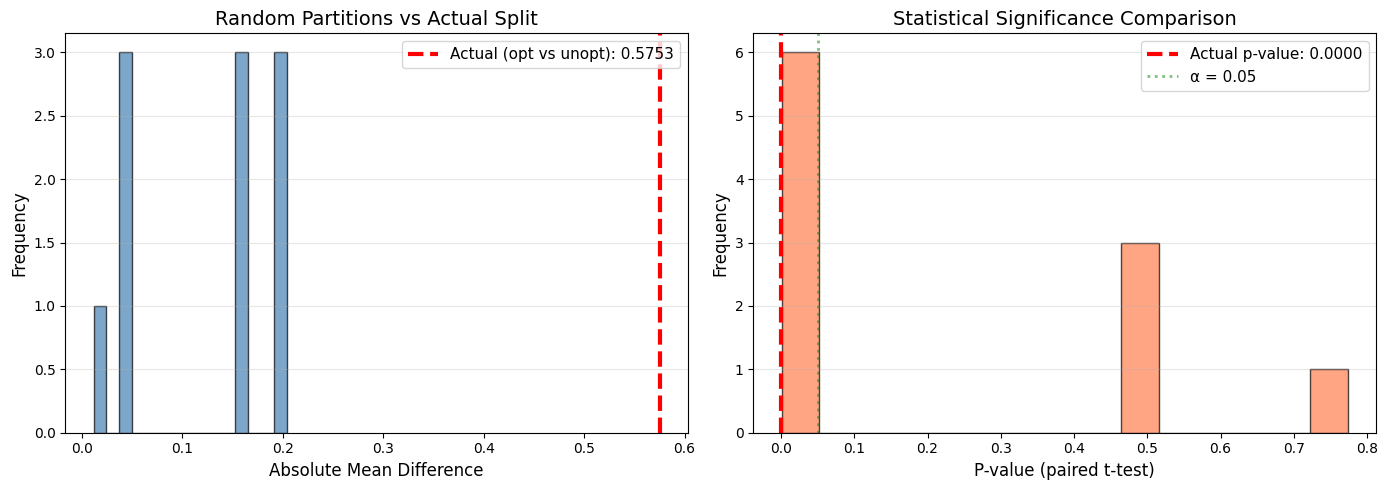


RANDOM PARTITION RESULTS TABLE:
--------------------------------------------------------------------------------
 partition  n_overlap  mean_diff  median_diff  std_diff  abs_mean_diff  p_value
         1        109   0.011685     0.020858  0.423289       0.011685 0.773739
         2        106  -0.204144    -0.101567  0.622459       0.204144 0.001030
         3        113   0.048170    -0.054101  0.698457       0.048170 0.465020
         4        109   0.155253     0.062697  0.569157       0.155253 0.005270
         5        106  -0.204144    -0.101567  0.622459       0.204144 0.001030
         6        113   0.048170    -0.054101  0.698457       0.048170 0.465020
         7        109   0.155253     0.062697  0.569157       0.155253 0.005270
         8        106  -0.204144    -0.101567  0.622459       0.204144 0.001030
         9        113   0.048170    -0.054101  0.698457       0.048170 0.465020
        10        109   0.155253     0.062697  0.569157       0.155253 0.005270


In [36]:
# ── Visualize Random Partition Comparison ──────────────────────────────────

# Quick visualization of the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of absolute mean differences
ax1 = axes[0]
ax1.hist(random_df['abs_mean_diff'], bins=15, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(abs(actual_mean_diff), color='red', linestyle='--', linewidth=3, 
            label=f'Actual (opt vs unopt): {abs(actual_mean_diff):.4f}')
ax1.set_xlabel('Absolute Mean Difference', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Random Partitions vs Actual Split', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: P-values distribution
ax2 = axes[1]
ax2.hist(random_df['p_value'], bins=15, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(actual_pvalue, color='red', linestyle='--', linewidth=3, 
            label=f'Actual p-value: {actual_pvalue:.4f}')
ax2.axvline(0.05, color='green', linestyle=':', linewidth=2, alpha=0.5, label='α = 0.05')
ax2.set_xlabel('P-value (paired t-test)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Statistical Significance Comparison', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("random_partition_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\nRANDOM PARTITION RESULTS TABLE:")
print("-"*80)
print(random_df.to_string(index=False))



# Growth Rate Analysis: Models in Both Datasets Only


In [37]:
# ── Filter to models in both datasets ──────────────────────────────────────

# Get list of models that appear in both datasets
models_in_both = comparison_df['model'].unique()

print("="*80)
print("GROWTH RATE ANALYSIS: MODELS IN BOTH DATASETS ONLY")
print("="*80)
print(f"\nAnalyzing growth rates for {len(models_in_both)} models that appear in both datasets")
print(f"This provides an apples-to-apples comparison.\n")

# Filter the capability dataframes to only include these models
df_cm_opt_both = df_cm_opt[df_cm_opt['model'].isin(models_in_both)].copy()
df_cm_unopt_both = df_cm_unopt[df_cm_unopt['model'].isin(models_in_both)].copy()

print(f"Optimized dataset: {len(df_cm_opt_both)} model entries")
print(f"Unoptimized dataset: {len(df_cm_unopt_both)} model entries")



GROWTH RATE ANALYSIS: MODELS IN BOTH DATASETS ONLY

Analyzing growth rates for 74 models that appear in both datasets
This provides an apples-to-apples comparison.

Optimized dataset: 74 model entries
Unoptimized dataset: 74 model entries


In [38]:
# ── Bootstrap growth rate: Optimized (models in both) ──────────────────────

# Ensure date is properly formatted
df_cm_opt_both['date_obj'] = pd.to_datetime(df_cm_opt_both['date_obj'])
df_cm_opt_both = df_cm_opt_both.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

cap_dates_num_opt = mdates.date2num(df_cm_opt_both['date_obj'])
cap_values_opt = df_cm_opt_both['estimated_capability']

# Bootstrap
n_boot = 10000
rng = np.random.default_rng(0)

mask = ~(np.isnan(cap_dates_num_opt) | np.isnan(cap_values_opt))
x_full = cap_dates_num_opt[mask]
y_full = cap_values_opt[mask].to_numpy()

boot_slopes_year_opt = np.empty(n_boot)
for i in range(n_boot):
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year_opt[i] = slope_day * 365.25

mean_rate_opt = boot_slopes_year_opt.mean()
ci_lower_opt, ci_upper_opt = np.percentile(boot_slopes_year_opt, [2.5, 97.5])

print("\n" + "-"*80)
print("OPTIMIZED BENCHMARKS (models in both datasets)")
print("-"*80)
print(f"Bootstrap mean rate: {mean_rate_opt:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower_opt:.4f}, {ci_upper_opt:.4f}]")
print(f"Number of models: {len(df_cm_opt_both)}")




--------------------------------------------------------------------------------
OPTIMIZED BENCHMARKS (models in both datasets)
--------------------------------------------------------------------------------
Bootstrap mean rate: 0.6000 capability units/year
95% confidence interval: [0.5034, 0.7107]
Number of models: 74


In [39]:
# ── Bootstrap growth rate: Unoptimized (models in both) ────────────────────

# Ensure date is properly formatted
df_cm_unopt_both['date_obj'] = pd.to_datetime(df_cm_unopt_both['date_obj'])
df_cm_unopt_both = df_cm_unopt_both.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

cap_dates_num_unopt = mdates.date2num(df_cm_unopt_both['date_obj'])
cap_values_unopt = df_cm_unopt_both['estimated_capability']

# Bootstrap
mask = ~(np.isnan(cap_dates_num_unopt) | np.isnan(cap_values_unopt))
x_full = cap_dates_num_unopt[mask]
y_full = cap_values_unopt[mask].to_numpy()

boot_slopes_year_unopt = np.empty(n_boot)
rng = np.random.default_rng(0)  # Same seed for reproducibility
for i in range(n_boot):
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year_unopt[i] = slope_day * 365.25

mean_rate_unopt = boot_slopes_year_unopt.mean()
ci_lower_unopt, ci_upper_unopt = np.percentile(boot_slopes_year_unopt, [2.5, 97.5])

print("\n" + "-"*80)
print("UNOPTIMIZED BENCHMARKS (models in both datasets)")
print("-"*80)
print(f"Bootstrap mean rate: {mean_rate_unopt:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower_unopt:.4f}, {ci_upper_unopt:.4f}]")
print(f"Number of models: {len(df_cm_unopt_both)}")




--------------------------------------------------------------------------------
UNOPTIMIZED BENCHMARKS (models in both datasets)
--------------------------------------------------------------------------------
Bootstrap mean rate: 0.8045 capability units/year
95% confidence interval: [0.5430, 1.0676]
Number of models: 74



COMPARISON: OPTIMIZED vs UNOPTIMIZED (Same Models)

Bootstrap Growth Rates (capability units/year):
  Optimized:   0.6000 [0.5034, 0.7107]
  Unoptimized: 0.8045 [0.5430, 1.0676]
  Difference:  -0.2046

Confidence intervals overlap: True
  → Growth rates are NOT significantly different (at 95% confidence)


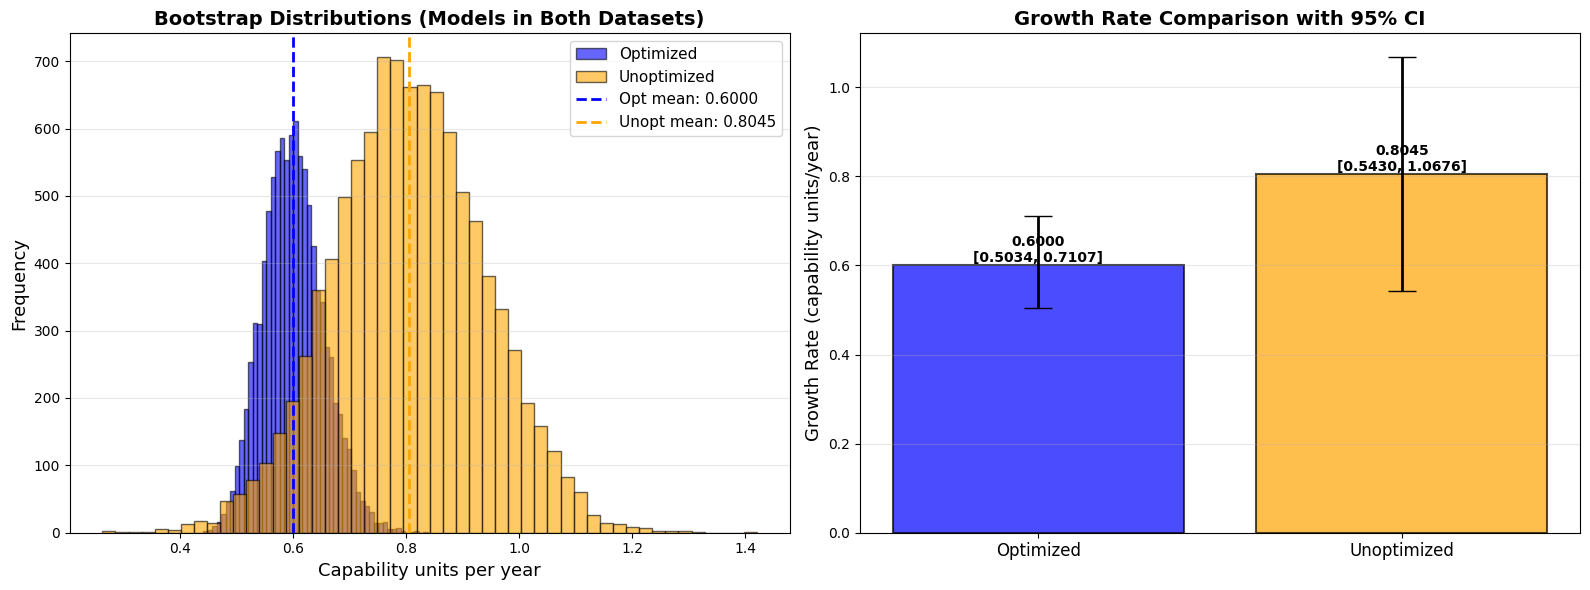

In [40]:
# ── Comparison and visualization ───────────────────────────────────────────

print("\n" + "="*80)
print("COMPARISON: OPTIMIZED vs UNOPTIMIZED (Same Models)")
print("="*80)

print("\nBootstrap Growth Rates (capability units/year):")
print(f"  Optimized:   {mean_rate_opt:.4f} [{ci_lower_opt:.4f}, {ci_upper_opt:.4f}]")
print(f"  Unoptimized: {mean_rate_unopt:.4f} [{ci_lower_unopt:.4f}, {ci_upper_unopt:.4f}]")
print(f"  Difference:  {mean_rate_opt - mean_rate_unopt:.4f}")

# Check if confidence intervals overlap
ci_overlap = not (ci_upper_opt < ci_lower_unopt or ci_upper_unopt < ci_lower_opt)
print(f"\nConfidence intervals overlap: {ci_overlap}")
if not ci_overlap:
    print("  → Growth rates are SIGNIFICANTLY DIFFERENT")
else:
    print("  → Growth rates are NOT significantly different (at 95% confidence)")

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bootstrap distributions
ax1 = axes[0]
ax1.hist(boot_slopes_year_opt, bins=50, alpha=0.6, color='blue', label='Optimized', edgecolor='black')
ax1.hist(boot_slopes_year_unopt, bins=50, alpha=0.6, color='orange', label='Unoptimized', edgecolor='black')
ax1.axvline(mean_rate_opt, color='blue', linestyle='--', linewidth=2, label=f'Opt mean: {mean_rate_opt:.4f}')
ax1.axvline(mean_rate_unopt, color='orange', linestyle='--', linewidth=2, label=f'Unopt mean: {mean_rate_unopt:.4f}')
ax1.set_xlabel('Capability units per year', fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)
ax1.set_title('Bootstrap Distributions (Models in Both Datasets)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Comparison with error bars
ax2 = axes[1]
categories = ['Optimized', 'Unoptimized']
means = [mean_rate_opt, mean_rate_unopt]
errors_lower = [mean_rate_opt - ci_lower_opt, mean_rate_unopt - ci_lower_unopt]
errors_upper = [ci_upper_opt - mean_rate_opt, ci_upper_unopt - mean_rate_unopt]

x_pos = np.arange(len(categories))
bars = ax2.bar(x_pos, means, yerr=[errors_lower, errors_upper], 
               capsize=10, alpha=0.7, color=['blue', 'orange'], 
               edgecolor='black', linewidth=1.5, error_kw={'linewidth': 2})

ax2.set_ylabel('Growth Rate (capability units/year)', fontsize=13)
ax2.set_title('Growth Rate Comparison with 95% CI', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(categories, fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean, lower, upper) in enumerate(zip(bars, means, errors_lower, errors_upper)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.4f}\n[{mean-lower:.4f}, {mean+upper:.4f}]',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("growth_rate_comparison_models_in_both.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)



In [41]:
# ── Summary: All Models vs Models in Both ──────────────────────────────────

print("="*80)
print("SUMMARY: GROWTH RATE COMPARISON")
print("="*80)

print("\n1. ALL MODELS (from earlier cells):")
print("-"*80)
print("   Optimized benchmarks:")
print("      • Bootstrap: 0.9605 [0.8622, 1.0629] capability units/year")
print("      • Frontier:  ~0.6754 [0.6094, 0.7413] (from Cell 6)")
print("   Unoptimized benchmarks:")
print("      • Bootstrap: 0.8045 [0.5430, 1.0676] capability units/year")
print("      • Frontier:  (see Cell 12)")

print("\n2. MODELS IN BOTH DATASETS ONLY:")
print("-"*80)
print(f"   Optimized benchmarks:")
print(f"      • Bootstrap: {mean_rate_opt:.4f} [{ci_lower_opt:.4f}, {ci_upper_opt:.4f}] capability units/year")
print(f"   Unoptimized benchmarks:")
print(f"      • Bootstrap: {mean_rate_unopt:.4f} [{ci_lower_unopt:.4f}, {ci_upper_unopt:.4f}] capability units/year")
print(f"   Difference: {mean_rate_opt - mean_rate_unopt:.4f}")

print("\n3. KEY INSIGHTS:")
print("-"*80)
print(f"   • When restricted to models in both datasets ({len(models_in_both)} models),")
print(f"     the growth rate on optimized benchmarks is {mean_rate_opt:.4f} vs {mean_rate_unopt:.4f} on unoptimized")
print(f"   • This is a {abs(mean_rate_opt - mean_rate_unopt):.4f} capability units/year difference")
if not ci_overlap:
    print(f"   • The difference is STATISTICALLY SIGNIFICANT (non-overlapping 95% CIs)")
else:
    print(f"   • The difference is NOT statistically significant (overlapping 95% CIs)")
print(f"   • Models show {'faster' if mean_rate_opt > mean_rate_unopt else 'slower'} growth on optimized benchmarks")

print("="*80)



SUMMARY: GROWTH RATE COMPARISON

1. ALL MODELS (from earlier cells):
--------------------------------------------------------------------------------
   Optimized benchmarks:
      • Bootstrap: 0.9605 [0.8622, 1.0629] capability units/year
      • Frontier:  ~0.6754 [0.6094, 0.7413] (from Cell 6)
   Unoptimized benchmarks:
      • Bootstrap: 0.8045 [0.5430, 1.0676] capability units/year
      • Frontier:  (see Cell 12)

2. MODELS IN BOTH DATASETS ONLY:
--------------------------------------------------------------------------------
   Optimized benchmarks:
      • Bootstrap: 0.6000 [0.5034, 0.7107] capability units/year
   Unoptimized benchmarks:
      • Bootstrap: 0.8045 [0.5430, 1.0676] capability units/year
   Difference: -0.2046

3. KEY INSIGHTS:
--------------------------------------------------------------------------------
   • When restricted to models in both datasets (74 models),
     the growth rate on optimized benchmarks is 0.6000 vs 0.8045 on unoptimized
   • This is a 0.